# LSTM models for track finding with 2D ACTS data

In this notebook, we apply the LSTM track-finding models to some 2D ACTS data.

In [1]:
# System
from __future__ import print_function
import os

# Externals
import numpy as np
import matplotlib.pyplot as plt

# Locals
from drawing import draw_2d_input_and_pred, draw_2d_event
from models import build_lstm_model

# Magic
%matplotlib notebook

Using Theano backend.


## Data utilities

Some helper functions for extracting, cleaning, binning the data.

In [2]:
def calc_eta(theta):
    """Calculates eta from a theta value or flat array"""
    return -1. * np.log(np.tan(theta / 2.))

def calc_phi(rphi, r):
    """Calculates phi from rphi"""
    return rphi / r
# I vectorize it to work on an array of arrays
calc_phi = np.vectorize(calc_phi, otypes='O')

def filter_samples(idx, *arrays):
    """Apply a filter index to a list of arrays"""
    return map(lambda x: x[idx], arrays)

def filter_objects(idx, *arrays):
    """
    Apply array of filter indices to some object arrays.
    Each input array should be an array of arrays (dtype='O').
    """
    filt_func = np.vectorize(lambda x: x[idx], otypes='O')
    return map(lambda a: np.stack(filt_func(a)), arrays)

In [3]:
class ActsData():
    """Empty class for setting variables as attributes"""
    pass

def load_data(filenames):
    """
    Retrieve data from some input files.
    Returns a data object with attributes for each numpy array.
    """
    d = ActsData()
    f = np.concatenate([np.load(f, encoding='bytes') for f in filenames])
    # Track level truth quantities
    d.true_theta = f['truth_Theta']
    d.true_eta = calc_eta(d.true_theta)
    d.true_phi = f['truth_Phi']
    d.true_qop = f['truth_QoverP']
    d.true_pt = np.abs(1/d.true_qop)
    # Detector hit measurements
    d.nstep = f['Filter_nSteps']
    d.rphi = f['Meas_RPHI']
    d.z = f['Meas_z']
    d.r = f['Cyl_R']
    d.phi = calc_phi(d.rphi, d.r)
    return d

def clean_data(data, fix_phi=False):
    """
    Cleans up the data, selecting barrel tracks and good hits.
    """
    barrel_tracks = np.abs(data.true_eta) < 1
    d = ActsData()

    # filter out all tracks not perfectly in the barrel.
    d.true_theta, d.true_eta, d.true_phi, d.true_qop, d.true_pt = (
        filter_samples(barrel_tracks, data.true_theta, data.true_eta,
                       data.true_phi, data.true_qop, data.true_pt))
    d.nstep, d.rphi, d.z, d.r, d.phi = (
        filter_samples(barrel_tracks, data.nstep, data.rphi,
                       data.z, data.r, data.phi))

    # To select the actual layer hits, I select the indices of the steps
    # I want. I'm currently taking the middle of each detector layer triplet,
    # and ignoring all of the apparent "auxiliary" steps. This assumes
    # all tracks have the fixed 31 steps as previously discovered, so it's
    # a bit fragile and will need to be updated if the data changes.
    assert np.all(d.nstep == 31)
    #good_hit_idxs = np.array([1, 4, 9, 11, 14, 17, 20, 24, 27])
    good_hit_idxs = np.array([2, 5, 8, 11, 15, 18, 21, 25, 28])
    d.rphi, d.z, d.r, d.phi = filter_objects(
        good_hit_idxs, d.rphi, d.z, d.r, d.phi)

    # Current data has some funny artifacts in phi.
    # Here is a shitty, hacky correction. Needs to be fixed upstream.
    if fix_phi:
        for i in range(d.phi.shape[1]):
            phi = d.phi[:,i]
            phi = phi * np.pi * 2 / (phi.max() - phi.min())
            d.phi[:,i] = phi - phi.min() - np.pi

    # Calculate theta
    d.theta = np.arctan(d.r / d.z)
    # Fix negative values so theta ranges from (0, pi)
    negidx = d.theta < 0
    d.theta[negidx] = d.theta[negidx] + np.pi
    d.eta = calc_eta(d.theta)

    return d

def hist2d_r_phi(data, det_shape, phi_range=(-3.1416, 3.1416)):
    """Takes the track hit data and bins it in 2D histogram detector images"""
    num_tracks = len(data.true_pt)
    # Initial structure with zeros
    tracks = np.zeros((num_tracks,) + det_shape)
    # Loop over tracks and layers
    for itrk in range(num_tracks):
        for jlay in range(det_shape[0]):
            # Convert coordinates for this layer to a histogram
            tracks[itrk, jlay] = np.histogram(
                data.phi[itrk, jlay:jlay+1],
                bins=det_shape[1], range=phi_range)[0]
    # Check that all tracks have one hit in every layer
    assert np.all(tracks.sum(axis=2) == 1.)
    return tracks

def combine_events(events, num_combine):
    """Combine detector image events together by num_combine"""
    combined_events = []
    for ievt in range(int(events.shape[0]/num_combine)):
        istart = num_combine * ievt
        iend = num_combine * (ievt + 1)
        combined_events.append(sum(events[istart:iend]))
    return np.stack(combined_events)

In [4]:
def draw_model_event(event_input, event_target, event_pred,
                     figsize=(12,6), cmap='jet'):
    fig = plt.figure(figsize=figsize)
    plt.subplot(131)
    draw_2d_event(event_input, title='Input', cmap=cmap)
    plt.subplot(132)
    draw_2d_event(event_target, title='Target', cmap=cmap)
    plt.subplot(133)
    draw_2d_event(event_pred, title='Model prediction', cmap=cmap)
    return fig

## Load the data

In [5]:
#input_file = '/Users/sfarrell/Atlas/TrackML/acts_dev/data/KFTest_0000.npy'
input_dir = '/Users/sfarrell/Atlas/TrackML/acts_dev/data'
input_files = [os.path.join(input_dir, f) for f in os.listdir(input_dir)
               if f.startswith('KFTest') and f.endswith('.npy')]

In [7]:
# Load the raw data
raw_data = load_data(input_files)
num_raw_tracks = len(raw_data.true_theta)
# Clean the data
data = clean_data(raw_data, fix_phi=True)
num_tracks = len(data.true_theta)
print('Number of raw tracks: %i, cleaned tracks: %i' % (num_raw_tracks, num_tracks))

Number of raw tracks: 100000, cleaned tracks: 26674


In [8]:
# Detector binning
num_det_layers = 9
num_phi_bins = 32
seed_size = 3
phi_range = (-3.1416, 3.1416)
det_shape = (num_det_layers, num_phi_bins)

tracks_per_event = 2
num_events = int(num_tracks / tracks_per_event)

In [9]:
# Bin the data into discrete detector images
tracks = hist2d_r_phi(data, det_shape, phi_range=phi_range)

# Combine tracks into events
events = combine_events(tracks, tracks_per_event)

## Basic LSTM model

In [10]:
# Since we combined tracks together to make events,
# we need to repeat each event for each corresponding signal track
train1_input = np.repeat(events, tracks_per_event, axis=0)
train1_target = tracks[:num_events*tracks_per_event]

# Set the seeds
train1_input[:,:seed_size,:] = train1_target[:,:seed_size,:]

In [14]:
# Model config
hidden_dim = 32

# Training config
batch_size = 64
num_epoch = 10

In [15]:
model1 = build_lstm_model(num_det_layers, num_phi_bins, hidden_dim=16)
model1.summary()

history1 = model1.fit(train1_input, train1_target, nb_epoch=num_epoch, batch_size=batch_size)
train1_pred = model1.predict(train1_input)

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_2 (InputLayer)             (None, 9, 32)         0                                            
____________________________________________________________________________________________________
lstm_2 (LSTM)                    (None, 9, 16)         3136        input_2[0][0]                    
____________________________________________________________________________________________________
timedistributed_2 (TimeDistribut (None, 9, 32)         544         lstm_2[0][0]                     
Total params: 3,680
Trainable params: 3,680
Non-trainable params: 0
____________________________________________________________________________________________________
Epoch 1/10
26674/26674 [==============================] - 3s - loss: 1.3519 - acc: 0.8650     

<IPython.core.display.Javascript object>


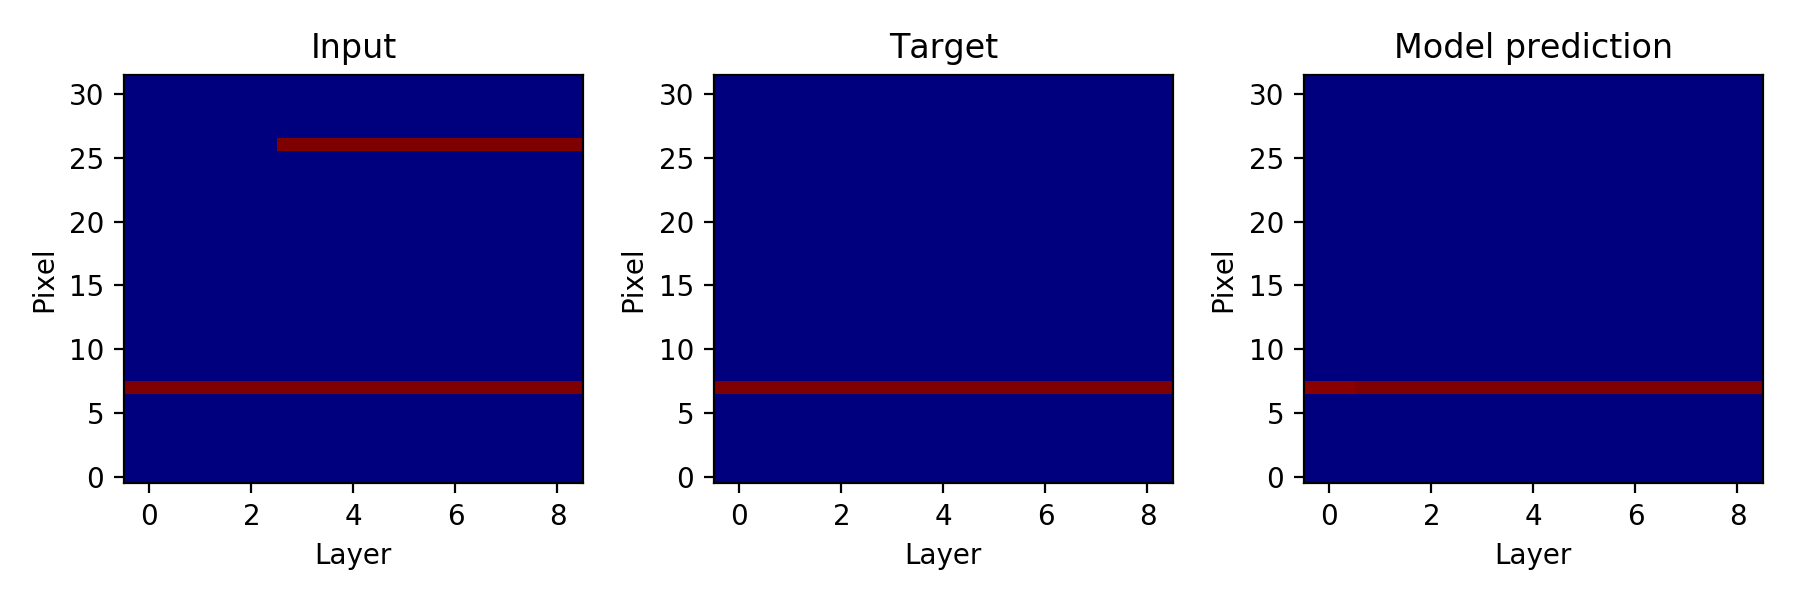

<IPython.core.display.Javascript object>


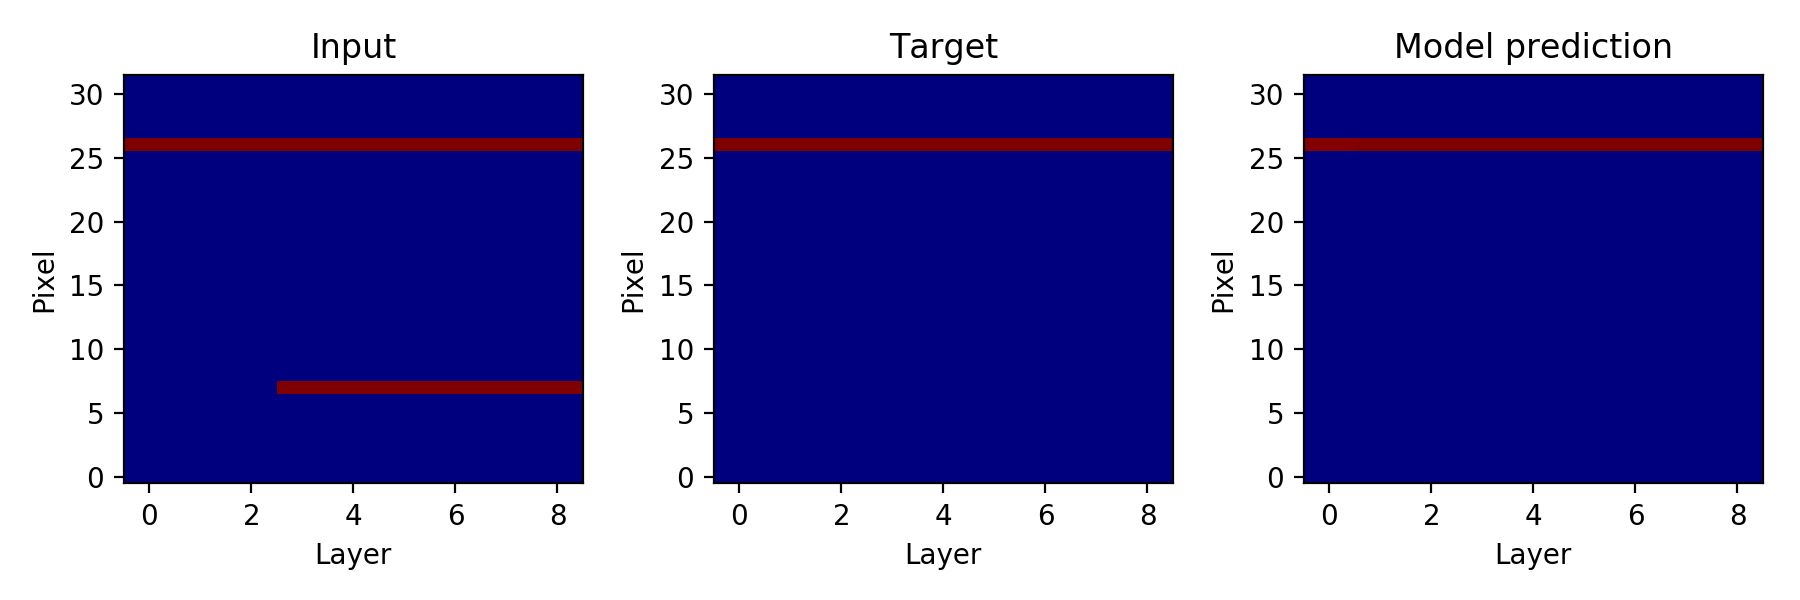

In [19]:
i = 0
for i in [0, 1]:
    fig = draw_model_event(train1_input[i], train1_target[i], train1_pred[i], figsize=(9,3))

## Multi-track LSTM model
Now let's try the multi-track LSTM model, which is fed the seeds as separate inputs and has an output for each track.

The model code is copied from the LSTM_Toy_MultiTrack notebook.

In [21]:
from keras import models
from keras import layers

In [23]:
def build_multi_chan_model(det_shape, num_tracks=2, hidden_dim=100):
    """
    Construct a basic multi-channel LSTM model.
    This model does a per-channel softmax over the pixels in each layer.
    """
    det_depth, det_width = det_shape
    # Separate input channels (num_tracks + a raw input channel)
    inputs = [layers.Input(shape=det_shape) for i in range(num_tracks+1)]
    merged_inputs = layers.merge(inputs, mode='concat', concat_axis=2)
    # Flatten out the channel dimension
    flat_inputs = layers.Reshape((det_depth, det_width * (num_tracks+1)))(merged_inputs)
    # Apply the LSTM
    hidden = layers.LSTM(hidden_dim, return_sequences=True)(flat_inputs)
    hidden = layers.TimeDistributed(layers.Dense(hidden_dim))(hidden)
    # Dense layer transforms to concatenated output shape
    hidden = layers.TimeDistributed(layers.Dense(det_width*num_tracks))(hidden)
    # Split output channels
    outputs = [layers.Lambda(lambda x: x[:,:,i*det_width:(i+1)*det_width])(hidden)
               for i in range(num_tracks)]
    # Apply softmax to each layer in each output channel
    outputs = [layers.TimeDistributed(layers.Activation('softmax'))(output)
               for output in outputs]
    # Compile the model
    model = models.Model(input=inputs, output=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='Nadam', metrics=['accuracy'])
    return model

For this model I need a different data structure.
I need a list of inputs, where the first M elements are the track seeds,
and the last one is the full event:

[sig_tracks1, sig_tracks2, events]